In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim
import optimizer as opt

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=False), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=False), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[1, 10, 5, 11, 6, 7, 1, 2, 9, 10]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h14, cards=[2, 9, 3], doubled=False, drawn=True),
  Hand(score=h17, cards=[10, 7], doubled=False, drawn=False),
  <HandOutcome.LOSE: -1>),
 ('strat_nobust',
  Hand(score=h21, cards=[2, 9, 10], doubled=False, drawn=True),
  Hand(score=h17, cards=[10, 7], doubled=False, drawn=False),
  <HandOutcome.WIN: 1>)]

## Aggregate and summarize the data from the simulations

In [19]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [7, 7],
  'dealer_card': 4,
  'hand_end': [7, 7],
  'dealer_hand': [4, 5, 11],
  'outcome': <HandOutcome.LOSE: -1>},
 {'strategy': 'strat_dealer',
  'hand_start': [7, 7],
  'dealer_card': 4,
  'hand_end': [7, 7, 2, 4],
  'dealer_hand': [4, 5, 11],
  'outcome': <HandOutcome.WIN: 1>}]

In [20]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [21]:
def strat_simple_func(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple_func.name = 'simple'

strat_simple = bj.Strategy_wrapper(strat_simple_func)
sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card          hand_end    dealer_hand  \
 0   simple     [3, 9]           13        [3, 9, 12]     [13, 2, 7]   
 1   simple     [8, 3]            4         [8, 3, 5]      [4, 5, 9]   
 2   simple   [10, 11]           10          [10, 11]        [10, 9]   
 3   simple    [3, 12]           10       [3, 12, 13]  [10, 2, 2, 8]   
 4   simple     [2, 8]            8        [2, 8, 12]         [8, 9]   
 5   simple     [7, 3]           12  [7, 3, 2, 4, 11]        [12, 9]   
 6   simple     [5, 6]            3        [5, 6, 12]  [3, 13, 3, 5]   
 7   simple     [2, 8]           13         [2, 8, 9]    [13, 5, 10]   
 8   simple    [10, 8]           12           [10, 8]        [12, 8]   
 9   simple     [3, 8]           11         [3, 8, 9]       [11, 10]   
 
                    outcome  outcome_value outcome_name  
 0         HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE_DOUBLE           -2.0  LOSE_DOUBLE  
 2          HandOutcome.WIN     

In [22]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

In [25]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h22, cards=[5, 7, 2, 13], doubled=False, drawn=True),
  Hand(score=h21, cards=[2, 12, 2, 7], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False),
  Hand(score=h21, cards=[2, 12, 2, 7], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h20, cards=[5, 7, 8], doubled=True, drawn=True),
  Hand(score=h21, cards=[2, 12, 2, 7], doubled=False, drawn=True),
  <HandOutcome.LOSE_DOUBLE: -2>)]

In [27]:


sims = sim.run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5939  486     0       3575      -0.4728
<Action.HIT: 2>     6056           0  655  3289          0      -0.2767
<Action.STAND: 1>   6332           0    0  3668          0      -0.2664

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

In [30]:
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6397    0     0       3603      -0.5588
<Action.HIT: 2>     5312           0  821  3867          0      -0.1445
<Action.STAND: 1>   6397           0    0  3603          0      -0.2794
simple              5233           0  829  3938          0      -0.1295

In [31]:
sim.summarize_totals(sim.run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6014  683  3303      -0.2711
strat_cond    6333    0  3667      -0.2666

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5895    0     0       4105      -0.3580
<Action.HIT: 2>     5001           0  291  4708          0      -0.0293
<Action.STAND: 1>   5895           0    0  4105          0      -0.1790
simple              5895           0    0  4105          0      -0.1790

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3225  691     0       6084       0.5718
<Action.HIT: 2>     3260           0  673  6067          0       0.2807
<Action.STAND: 1>   5778           0    0  4222          0      -0.1556
simple              3156           0  679  6165          0       0.3009

In [34]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3237  663     0       6100       0.5726
 <Action.HIT: 2>     3244           0  687  6069          0       0.2825
 <Action.STAND: 1>   5750           0    0  4250          0      -0.1500)

In [35]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         152    8    0         40       -1.120
 <Action.HIT: 2>     159           0    6   35          0       -0.620
 <Action.STAND: 1>    70           0   21  109          0        0.195)

In [36]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          67    9    0        124         0.57
 <Action.HIT: 2>      53           0   10  137          0         0.42
 <Action.STAND: 1>     0           0   18  182          0         0.91)

In [37]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 3>': 0.61,
 '<Action.HIT: 2>': 0.355,
 '<Action.STAND: 1>': -0.28,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 3>,
 'winning_act_outcome': 0.61}

In [38]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         858   18    0        124       -1.468
 <Action.HIT: 2>     831           0   24  145          0       -0.686
 <Action.STAND: 1>   568           0  140  292          0       -0.276)

In [39]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h09     s11                    -0.8           -0.300              -0.80   
        h02                     0.2            0.200              -0.20   
        h03                     1.0            0.450               0.30   
        h04                     0.4            0.100              -0.20   
        h05                     0.8            0.425               0.00   
...                             ...              ...                ...   
s21     h06                     0.1            0.050               0.90   
        h07                     1.6            0.400               1.00   
        h08                     0.4            0.125               0.90   
        h09                     0.9            0.400               0.95   
        h10                     0.4           -0.450               0.65   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h09     s11         Action.HIT                -0.30  
        h02      Action.DOUBLE                 0.20  
        h03      Action.DOUBLE                 1.00  
        h04      Action.DOUBLE                 0.40  
        h05      Action.DOUBLE                 0.80  
...                        ...                  ...  
s21     h06       Action.STAND                 0.90  
        h07      Action.DOUBLE                 1.60  
        h08       Action.STAND                 0.90  
        h09       Action.STAND                 0.95  
        h10       Action.STAND                 0.65  

[250 rows x 5 columns]

In [40]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

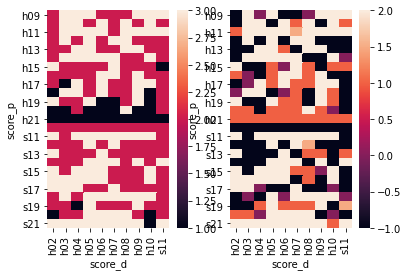

In [41]:


%prun -s cumulative opt.run_iteration(1, strat_simple, None)

In [42]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = opt.gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(   strategy hand_start  dealer_card      hand_end  dealer_hand  \
 0    simple    [6, 10]            6       [6, 10]    [6, 6, 7]   
 1  memoized    [6, 10]            6       [6, 10]    [6, 6, 7]   
 2    simple     [5, 2]            7    [5, 2, 12]   [7, 3, 10]   
 3  memoized     [5, 2]            7  [5, 2, 5, 5]   [7, 3, 10]   
 4    simple    [13, 6]            7    [13, 6, 1]       [7, 1]   
 5  memoized    [13, 6]            7    [13, 6, 2]       [7, 1]   
 6    simple     [3, 6]            6     [3, 6, 8]  [6, 12, 12]   
 7  memoized     [3, 6]            6    [3, 6, 10]  [6, 12, 12]   
 8    simple   [11, 13]            6      [11, 13]    [6, 7, 9]   
 9  memoized   [11, 13]            6      [11, 13]    [6, 7, 9]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3  HandOutcome.LOSE           -1.0         LOSE  
 4  Ha

0
1
('h09', 'h04') Action.DOUBLE Action.HIT
('h09', 'h05') Action.DOUBLE Action.HIT
('h09', 'h07') Action.HIT Action.DOUBLE
('h09', 'h08') Action.DOUBLE Action.HIT
('h10', 'h04') Action.DOUBLE Action.HIT
('h10', 'h05') Action.DOUBLE Action.HIT
('h10', 'h07') Action.DOUBLE Action.HIT
('h10', 'h08') Action.DOUBLE Action.HIT
('h10', 'h10') Action.HIT Action.DOUBLE
('h11', 's11') Action.HIT Action.DOUBLE
('h11', 'h08') Action.DOUBLE Action.HIT
('h11', 'h09') Action.DOUBLE Action.HIT
('h11', 'h10') Action.DOUBLE Action.HIT
('h12', 'h02') Action.HIT Action.STAND
('h13', 'h02') Action.STAND Action.HIT
('h13', 'h03') Action.STAND Action.HIT
('h13', 'h04') Action.HIT Action.STAND
('h13', 'h05') Action.STAND Action.HIT
('h13', 'h06') Action.STAND Action.HIT
('h13', 'h09') Action.HIT Action.DOUBLE
('h13', 'h10') Action.HIT Action.STAND
('h14', 'h03') Action.STAND Action.HIT
('h14', 'h06') Action.STAND Action.HIT
('h14', 'h07') Action.HIT Action.DOUBLE
('h14', 'h09') Action.STAND Action.HIT
('h14'

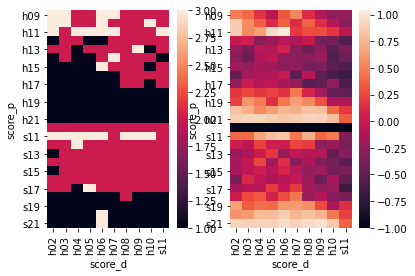

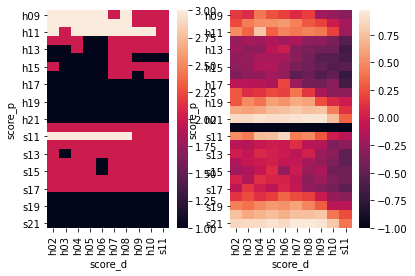

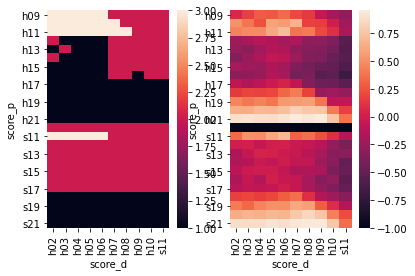

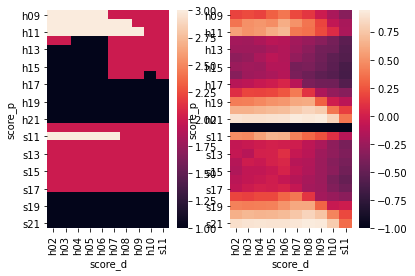

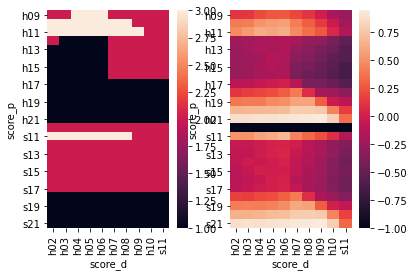

In [43]:


strategies = opt.derive_iterative_strategies(strat_simple, 5)
strategies

In [44]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card  hand_end dealer_hand           outcome  \
 0   simple   [13, 11]           10  [13, 11]  [10, 4, 6]  HandOutcome.PUSH   
 1  iter(1)   [13, 11]           10  [13, 11]  [10, 4, 6]  HandOutcome.PUSH   
 2  iter(2)   [13, 11]           10  [13, 11]  [10, 4, 6]  HandOutcome.PUSH   
 3  iter(3)   [13, 11]           10  [13, 11]  [10, 4, 6]  HandOutcome.PUSH   
 4  iter(4)   [13, 11]           10  [13, 11]  [10, 4, 6]  HandOutcome.PUSH   
 5  iter(5)   [13, 11]           10  [13, 11]  [10, 4, 6]  HandOutcome.PUSH   
 6   simple    [8, 11]            6   [8, 11]   [6, 8, 9]   HandOutcome.WIN   
 7  iter(1)    [8, 11]            6   [8, 11]   [6, 8, 9]   HandOutcome.WIN   
 8  iter(2)    [8, 11]            6   [8, 11]   [6, 8, 9]   HandOutcome.WIN   
 9  iter(3)    [8, 11]            6   [8, 11]   [6, 8, 9]   HandOutcome.WIN   
 
    outcome_value outcome_name  
 0            0.0         PUSH  
 1            0.0         PUSH  
 2            0.0         PUSH

In [45]:
strategies